In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [3]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [5]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [26]:
print(NUM_CLASSES)

6


In [6]:
ds_name = "yeast_v5"
test_dirs, train_dirs = dataset_source(data_path)
stats_tuple = Statistics.per_dataset(test_dirs, train_dirs, save_name=ds_name)

12
working on a dataset with length: 1644


In [7]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [27]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_tuple)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [9]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


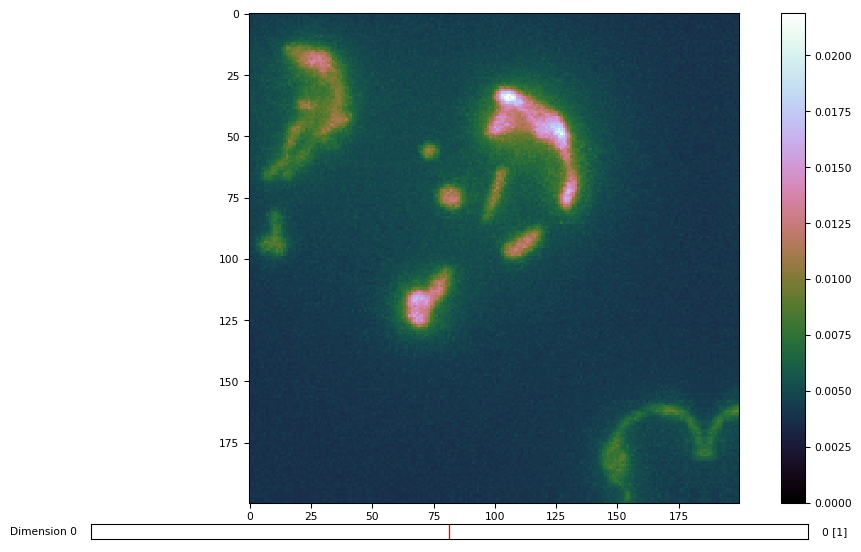

In [30]:
idx = 31
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 4), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [10]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [11]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [12]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [13]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], NUM_CLASSES), data)

In [14]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [15]:
wd=1e-5

In [16]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]: 0.5714%                                              
[1]:  0.0%
[2]:  0.0%
[3]: 0.6857%
[4]: 0.2286%
[5]:  0.0%
    5      2.367646   4.886537   0.31746   
[0]: 0.04286%                                             
[1]: 0.04286%
[2]:  0.0%
[3]: 0.4857%
[4]: 0.6286%
[5]:  0.0%
    6      1.968882   4.147687   0.314286  
[0]: 0.04286%                                             
[1]: 0.04286%
[2]:  0.0%
[3]: 0.4857%
[4]: 0.8857%
[5]:  0.0%
    7      1.69745    4.245504   0.31746   
[0]: 0.2143%                                              
[1]: 0.2286%
[2]:  0.0%
[3]:  0.4%
[4]: 0.7143%
[5]:  0.0%
    8      1.580909   4.0279     0.355556  
[0]:  0.3%                                                
[1]: 0.2714%
[2]:  0.0%
[3]: 0.4571%
[4]: 0.2714%
[5]:  0.0%
    9      1.452043   4.558552   0.314286  
[0]: 0.07143%                                             
[1]: 0.2857%
[2]:  0.0%
[3]: 0.4286%
[4]: 0.3857%
[5]:  0.0%
    10     1.362938   4.226114   0.301587  
[0]: 0.1571%      

[array([3.97661]), 0.33333333134651183]

In [17]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_C_Resnet_per_dataset_2')

[0]: 0.1857%                                              
[1]: 0.2143%
[2]:  0.0%
[3]: 0.6857%
[4]: 0.5143%
[5]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      1.032091   4.249561   0.311111  
[0]:  0.3%                                                
[1]: 0.3286%
[2]:  0.0%
[3]: 0.7143%
[4]:  0.1%
[5]:  0.0%
    1      1.101656   3.829866   0.31746   
[0]: 0.3143%                                              
[1]: 0.1714%
[2]:  0.0%
[3]:  0.6%
[4]: 0.3429%
[5]:  0.0%
    2      1.111009   4.169008   0.320635  
[0]: 0.1143%                                              
[1]: 0.1857%
[2]:  0.0%
[3]: 0.4857%
[4]:  0.4%
[5]:  0.0%
    3      1.104926   3.300764   0.326984  
[0]: 0.08571%                                             
[1]: 0.4286%
[2]:  0.0%
[3]: 0.3714%
[4]: 0.5571%
[5]:  0.0%
    4      1.090578   3.180165   0.314286  
[0]:  0.1%                                                
[1]: 0.1857%
[2]:  0.0%
[3]: 0.7143%
[4]: 0.5571%
[5]:  0.0%
    5      1.073601  

    49     0.836519   3.235738   0.355556  
[0]:  0.3%                                                 
[1]: 0.2571%
[2]:  0.0%
[3]: 0.5143%
[4]: 0.4571%
[5]:  0.0%
    50     0.846145   2.405047   0.368254  
[0]: 0.2714%                                               
[1]: 0.4286%
[2]:  0.0%
[3]: 0.5714%
[4]: 0.5429%
[5]:  0.0%
    51     0.898738   2.413019   0.4       
[0]: 0.3571%                                               
[1]: 0.1286%
[2]:  0.0%
[3]: 0.5143%
[4]: 0.7714%
[5]:  0.0%
    52     0.904105   2.446      0.368254  
[0]: 0.3857%                                               
[1]: 0.4143%
[2]:  0.0%
[3]: 0.4571%
[4]: 0.3857%
[5]:  0.0%
    53     0.876899   2.079483   0.387302  
[0]: 0.3143%                                               
[1]: 0.4429%
[2]:  0.0%
[3]: 0.4571%
[4]: 0.4143%
[5]:  0.0%
    54     0.874007   2.203311   0.374603  
[0]: 0.2286%                                               
[1]: 0.5143%
[2]:  0.0%
[3]: 0.5429%
[4]: 0.7286%
[5]:  0.0%
    55    

[array([2.08572]), 0.3460317464574935]

In [19]:
learn.load('Objective_C_Resnet_per_dataset_2')

In [21]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_C_Resnet_per_dataset_3')

[0]: 0.3714%                                               
[1]: 0.3857%
[2]:  0.0%
[3]:  0.6%
[4]: 0.5857%
[5]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.727718   2.370747   0.349206  
[0]: 0.3857%                                               
[1]: 0.4286%
[2]:  0.0%
[3]:  0.6%
[4]: 0.6143%
[5]:  0.0%
    1      0.734442   2.331331   0.355556  
[0]:  0.4%                                                 
[1]: 0.5286%
[2]:  0.0%
[3]: 0.5429%
[4]: 0.5857%
[5]:  0.0%
    2      0.741923   2.23059    0.365079  
[0]: 0.3857%                                               
[1]: 0.4286%
[2]:  0.0%
[3]: 0.5714%
[4]: 0.6429%
[5]: 0.02857%
    3      0.737511   2.276595   0.374603  
[0]: 0.3714%                                               
[1]: 0.4714%
[2]:  0.0%
[3]: 0.5714%
[4]: 0.6286%
[5]: 0.02857%
    4      0.739218   2.257686   0.352381  
[0]:  0.4%                                                 
[1]: 0.4714%
[2]:  0.0%
[3]: 0.5143%
[4]: 0.5857%
[5]:  0.0%
    5  

[array([2.09727]), 0.3999999990065893]

In [20]:
learn.load('')

[[55  0  0 12  3  0]                         
 [33  9  0 23  5  0]
 [33  1  0  0  1  0]
 [ 0  0  0 35  0  0]
 [39  2  0  8 21  0]
 [ 4  7  0 15  9  0]]


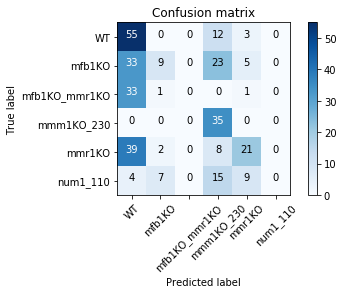

In [28]:
# analyze results
log_preds, y = learn.TTA()
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)